# Image Reconstruction from a Sinogram
## RE4017 Machine Vision Project 18/19
**Author:** Ryan Jennings - 15152324

### Project Description
Implement image reconstruction from parallel-projection sinograms using Python.  Use your code to reconstruct an image from the given sinogram (available as an image file, sinogram.png, in the Resources/Test Images folder).  Investigate the behaviour of backprojection reconstruction with and without ramp-filtering., and with Hamming-windowed ramp-filtering.

Provide your Python code and a short (3-5 page) report in pdf showing the behaviour of your code for: (a) Reconstruction without ramp-filtering from the given sinogram; (b) reconstruction with ramp-filtering, and; (c) reconstruction using a Hamming-windowed ramp-filter.  Result images should be given in the report, and commented on.  Please do not submit any .rar files.

You may work by yourself or in a group with up to two others (max group size is three).

Hints:  Use the scipack.fft routines from Python's scipack package for efficient discrete forward and inverse fast Fourier Transforms.  Use skimage.image.rotate from the skimage package for image rotation.

The image to be reconstructed has a 4:3 aspect ratio (i.e., it has 4/3 times more columns than rows), this will allow you to recover the image size from the sinogram.  The angle step can be recovered similarly form the sinogram dimensions.

Note also that this is a 3-channel sinogram, it represents a colour (RGB) image.  You will have to reconstruct each channel separately, then combine them into a final colour result image.

In [191]:
import cv2

import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack as fft

from scipy.misc import imsave
from skimage.transform import rotate

Read in the input sinogram and split it into 3 different colour channels.

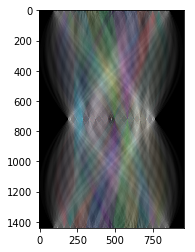

In [192]:
sinogram_img = cv2.imread('sinogram.png')
plt.imshow(sinogram_img)
blue_layer, green_layer, red_layer = cv2.split(sinogram_img)

Build laminogram function as used in radon transform sample code.

In [193]:
def build_laminogram(radonT):
    "Generate a laminogram by simple backprojection using the Radon Transform of an image, 'radonT'."
    laminogram = np.zeros((radonT.shape[1],radonT.shape[1]))
    dTheta = 180.0 / radonT.shape[0]
    for i in range(radonT.shape[0]):
        temp = np.tile(radonT[i],(radonT.shape[1],1))
        temp = rotate(temp, dTheta*i)
        laminogram += temp
    return laminogram

For cropping the image the height is obtained by finding the number of nonzero values from a sinogram column at the start while the width is obtained at the halway point of 90˚.

In [194]:
def crop(image):
    sinogram_width = int(np.count_nonzero(sinogram_img[0]) / 3)
    sinogram_midpoint = int((sinogram_img.shape[0] / 2))
    sinogram_height = int(np.count_nonzero(sinogram_img[sinogram_midpoint]) / 3)
    
    crop_width_start = int((image.shape[0]-1-sinogram_width) / 2)
    crop_height_start = int((image.shape[1]-1-sinogram_height) / 2)
    
    return image[crop_height_start:crop_height_start + sinogram_height,
                 crop_width_start:crop_width_start + sinogram_width]

### The Different Layers
When a laminogram of each layer is generated we can slightly see the small differences in the distribution of the different colours. For example the blue layer has a dark patch at the bottom of the inner circle which is brighter in the other channels.

Text(0.5, 1.0, 'Reconstructed Blue Layer')

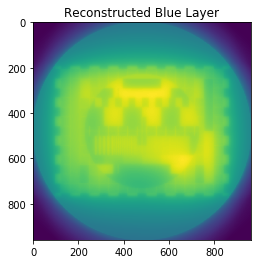

In [195]:
back_projected_blue = build_laminogram(blue_layer)
plt.figure()
plt.imshow(back_projected_blue)
plt.title('Reconstructed Blue Layer')

Text(0.5, 1.0, 'Reconstructed Green Layer')

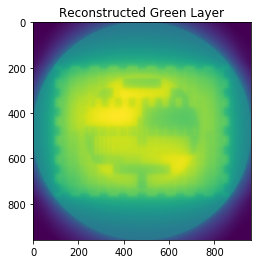

In [196]:
back_projected_green = build_laminogram(green_layer)
plt.figure()
plt.imshow(back_projected_green)
plt.title('Reconstructed Green Layer')

Text(0.5, 1.0, 'Reconstructed Red Layer')

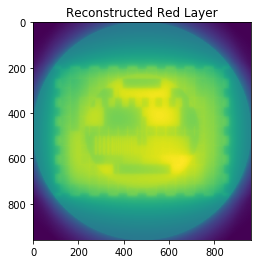

In [197]:
back_projected_red = build_laminogram(red_layer)
plt.figure()
plt.imshow(back_projected_red)
plt.title('Reconstructed Red Layer')

## (a) Reconstruction without ramp-filtering from the given sinogram
As seen in the following cells the reconstruction using backprojections is very blurry as was expected.

The RGB laminogram layers are combined and then normalised (to reduce the values to between 0 and 1 for a workable image) before plotting and cropping.

Text(0.5, 1.0, 'Cropped Image')

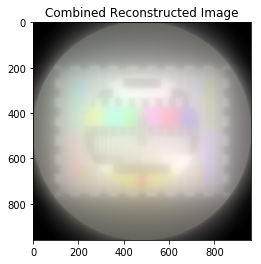

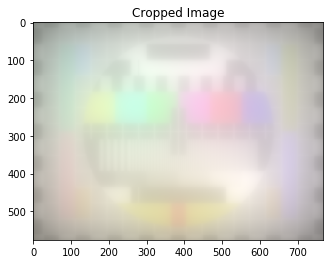

In [198]:
combined_img = np.dstack((back_projected_red, back_projected_green, back_projected_blue))
normalised_img = combined_img/combined_img.max()
plt.figure()
plt.imshow(normalised_img)
plt.title('Combined Reconstructed Image')

cropped_img = crop(normalised_img)
plt.figure()
plt.imshow(cropped_img)
plt.title('Cropped Image')

## (b) Reconstruction with ramp-filtering

We are able to achieve a better image when we remove the blurring by use of a ramp filter.
Adding a ramp filter before building the laminogram gives us a much clearer image but there are still some artefacts of the process left afterwards in the image.

In [199]:
def ramp_filter_ffts(image):
    # Translate image into the frequency domain using the fft
    freq_image = fft.rfft(image, axis=1)
    # The ramp filter
    ramp = np.floor(np.arange(0.5, freq_image.shape[1]//2 + 0.1, 0.5))
    # Filter by the frequency domain projections by multiplying each one by the ramp filter
    freq_image = freq_image * ramp
    # Convert back into spatial domain with the inverse fft
    spat_image = fft.irfft(freq_image, axis=1)
    return spat_image

In [200]:
ramp_filtered_blue = ramp_filter_ffts(blue_layer)
ramp_filtered_green = ramp_filter_ffts(green_layer)
ramp_filtered_red = ramp_filter_ffts(red_layer)

ramp_filtered_back_projected_blue = build_laminogram(ramp_filtered_blue)
ramp_filtered_back_projected_green = build_laminogram(ramp_filtered_green)
ramp_filtered_back_projected_red = build_laminogram(ramp_filtered_red)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Cropped Image')

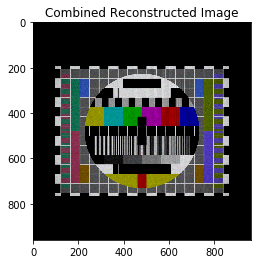

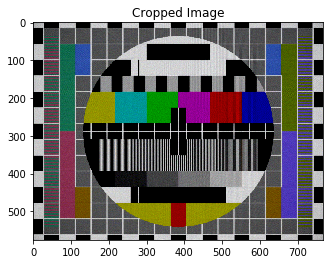

In [206]:
ramp_filtered_combined_img = np.dstack((ramp_filtered_back_projected_red,
                                        ramp_filtered_back_projected_green,
                                        ramp_filtered_back_projected_blue))
ramp_filtered_normalised_img = ramp_filtered_combined_img/ramp_filtered_combined_img.max()
plt.figure()
plt.imshow(ramp_filtered_normalised_img)
plt.title('Combined Reconstructed Image')

ramp_filtered_cropped_img = crop(ramp_filtered_normalised_img)
plt.figure()
plt.imshow(ramp_filtered_cropped_img)
plt.title('Cropped Image')

## (c) Reconstruction using a Hamming-windowed ramp-filter
Applying the hamming windowed ramp filter to the previous ramp filtered backprojections gives us the clearest image where artefacts are less visible and the image crisper.

In [202]:
def window_ramp_filter_ffts(ffts, c=True):
    """Ramp filter a 2-d array of 1-f FFTs (along rows), but also
       apply a Hamming or Hann windowing filter to the ramp in an attempt to
       suppress high-frequency ringing in the reconstruction."""
    ## N.B. Hamming window over the full length of a complex FFT is
    ## h(w) = c + (c-1)cos(2*pi*w/(M-1)), c = 0.54, where w ranges from
    ## 0 to M-1
    ## For the "real-FFT" FFTs we are using, with interspersed real and
    ## imaginary components, we have only M/2 data points in M entries
    ## in the FFTs, so
    ## h(w) = c + (1-c)cos(pi*w/(M/2-1)), c = 0.54, w = 0 .. M/2 - 1.
    ##
    ## N.B., set c = 0.5 for Hann window with sharper cutoff.
    ##
    M2 = ffts.shape[1] / 2.0
    ramp = np.floor(np.arange(0.5, M2 + 0.1, 0.5))
    if not isinstance(c, float) or c <= 0.0 or c >= 1.0: c = 0.54  ## Default to Hamming window.
    window = c + (1 - c) * np.cos(np.pi * ramp/float(M2))
    return ffts * ramp * window

In [203]:
window_ramp_filtered_back_projected_blue = window_ramp_filter_ffts(ramp_filtered_back_projected_blue)
window_ramp_filtered_back_projected_green = window_ramp_filter_ffts(ramp_filtered_back_projected_green)
window_ramp_filtered_back_projected_red = window_ramp_filter_ffts(ramp_filtered_back_projected_red)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Cropped Image')

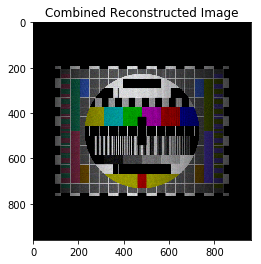

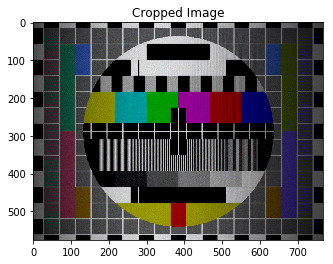

In [204]:
window_ramp_filtered_combined_img = np.dstack((window_ramp_filtered_back_projected_red,
                                               window_ramp_filtered_back_projected_green,
                                               window_ramp_filtered_back_projected_blue))
window_ramp_filtered_normalised_img = window_ramp_filtered_combined_img/window_ramp_filtered_combined_img.max()
plt.figure()
plt.imshow(window_ramp_filtered_normalised_img)
plt.title('Combined Reconstructed Image')

window_ramp_filtered_cropped_img = crop(window_ramp_filtered_normalised_img)
plt.figure()
plt.imshow(window_ramp_filtered_cropped_img)
plt.title('Cropped Image')